In [1]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import yellowbrick as yb

from fastai.tabular.data import TabularDataLoaders, TabularPandas
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback, RandomSplitter, range_of

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier



from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve



seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# declare file paths for the data we will be working on
data_path_1: str = '../../data/prepared/baseline/'
data_path_2: str = '../../data/prepared/timebased/'
modelPath  : str = '../models'


# list the names of the datasets we will be using
attacks : list = [ 'DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDPLag' ]
datasets: list = [
    "DNS_vs_benign.csv" , "LDAP_vs_benign.csv"    , "MSSQL_vs_benign.csv" , "NetBIOS_vs_benign.csv" ,
    "NTP_vs_benign.csv" , "Portmap_vs_benign.csv" , "SNMP_vs_benign.csv"  , "SSDP_vs_benign.csv"    ,
    "Syn_vs_benign.csv" , "TFTP_vs_benign.csv"    , "UDP_vs_benign.csv"   , "UDPLag_vs_benign.csv"  ,
]


# set up enumeration of experiment types
Baseline : int = 0
Timebased: int = 1


# print library and python versions for reproducibility
print(
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsklearn:\t{sklearn.__version__}
    \tyellowbrick:\t{yb.__version__}
    '''
)


    python:	3.7.9

    	fastai:		2.5.2
    	matplotlib:	3.3.2
    	numpy:		1.19.2
    	pandas:		1.2.1
    	sklearn:	0.23.2
    	yellowbrick:	1.3.post1
    


In [2]:
def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '.':
        filePathClean: str = filePath[17::]
        pickleDump: str = f'../../data/cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'../../data/cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}')
    
    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
        
    # if not, load data and cache it
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)

    
    return df


def run_experiment(df: pd.DataFrame, name: str) -> tuple:
    '''
        Run Classification experiment on the given dataset using Random Forest
        returns the 7-tuple with the following indicies:
        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = 'Label'
    if 'Protocol' in df.columns:
        categorical_features: list = ['Protocol']
    else:
        categorical_features: list = []
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]))


    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )


    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    mds = tabular_learner(dls)
    classes : list = list(mds.dls.vocab)


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a Support Vector Machine
    # using SciKitLearn and print the results 
    model = RandomForestClassifier()
    # model = SVC(C=1, gamma=0.1, kernel='rbf', random_state=seed)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(f'\tAccuracy: {accuracy_score(y_test, prediction)}\n')
    report = classification_report(y_test, prediction)
    print(report)

   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')


    # Now that the classifier has been created and trained, we pass out our training values
    # so that yellowbrick can use them to create various visualizations
    results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)

    return results


def visualize_learning_curve_train(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a learning curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # Track the learning curve of the classifier, here we want the 
    # training and validation scores to approach 1
    visualizer = LearningCurve(results[1], scoring='f1_weighted')
    visualizer.fit(results[3], results[4])
    visualizer.show()


def visualize_learning_curve_test(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a learning curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # Track the learning curve of the classifier, here we want the 
    # training and validation scores to approach 1
    visualizer = LearningCurve(results[1], scoring='f1_weighted')
    visualizer.fit(results[5], results[6])
    visualizer.show()


def visualize_confusion_matrix(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a confusion matrix

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ConfusionMatrix(results[1], classes=results[2], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.show()


def visualize_roc(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ROCAUC(results[1], classes=results[2], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_pr_curve(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(results[1], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_report(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ClassificationReport(results[1], classes=results[2], title=results[0], support=True)
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_class_balance(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.target.ClassBalance(labels=results[0])
    visualizer.fit(results[4], results[6])
    visualizer.show()


def get_file_path(directory: str):
    '''
        Closure that will return a function that returns the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func

In [3]:
# use the get_file_path closure to create a function that will return the path to a file
baseline_path  = get_file_path(data_path_1)
timebased_path = get_file_path(data_path_2)


# create a list of the paths to all of the dataset files
baseline_files  : list = list(map(baseline_path  , datasets))
timebased_files : list = list(map(timebased_path , datasets))


baseline_dfs  : map = map(load_data    , baseline_files )
timebased_dfs : map = map(load_data    , timebased_files)
experiments   : zip = zip(baseline_dfs , timebased_dfs  , attacks)

In [4]:
def experiment_runner():
    '''
        A generator that handles running the experiments
    '''
    num = 1
    for baseline, timebased, info in experiments:
        print(f'Running experiment #{num}:\t{info}')

        print('Baseline results')
        baseline_results = run_experiment(baseline, f'{info}_vs_benign_baseline')
        
        print('\nTime-based results')
        timebased_results = run_experiment(timebased, f'{info}_vs_benign_timebased')
        
        
        num += 1
        yield (baseline_results, timebased_results, info, num)


def do_experiment(num: int) -> tuple:
    '''
        A function that runs the specific experiment specified
    '''
    index = num - 1
    baseline = load_data(baseline_files[index])
    timebased = load_data(timebased_files[index])
    info = attacks[index]

    print(f'Running experiment #{num}:\t{info}')

    print('Baseline results\n')
    baseline_results = run_experiment(baseline, f'{info}_vs_benign_baseline')
    
    print('Time-based results\n')
    timebased_results = run_experiment(timebased, f'{info}_vs_benign_timebased')

    return (baseline_results, timebased_results, info, num)


experiment = experiment_runner()

In [5]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/DNS_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/DNS_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/DNS_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/DNS_vs_benign.csv.pickle
Running experiment #1:	DNS
Baseline results
	Accuracy: 0.9998225849374612

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.9985585026168722

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


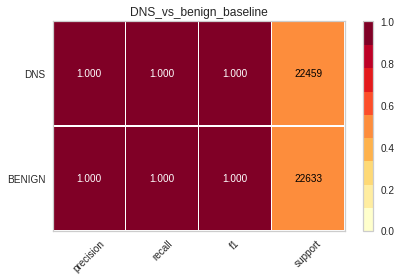

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


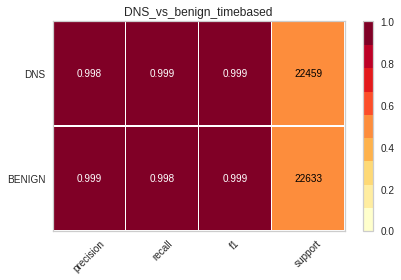

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


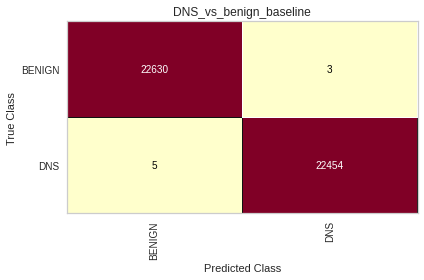

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


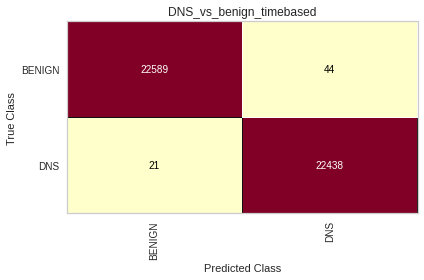

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


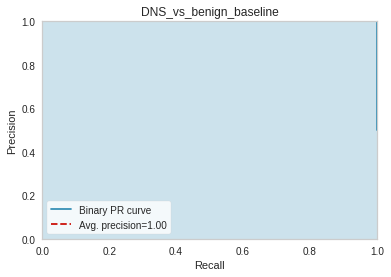

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


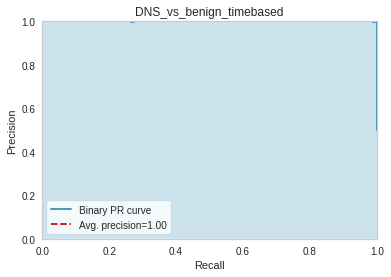

In [6]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [7]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/LDAP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/LDAP_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/LDAP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/LDAP_vs_benign.csv.pickle
Running experiment #2:	LDAP
Baseline results
	Accuracy: 0.9999112924687306

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.9998225849374612

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


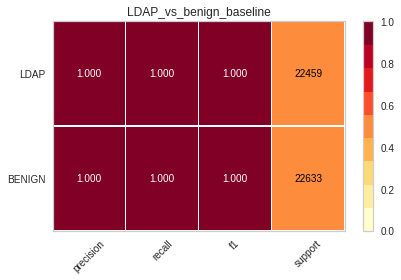

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


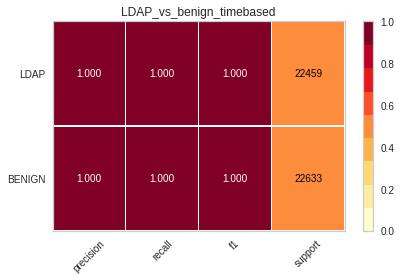

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


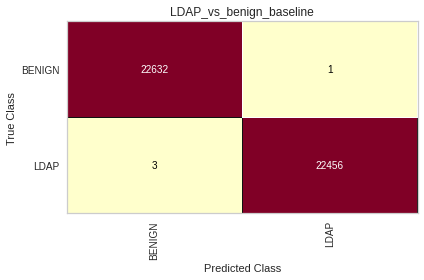

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


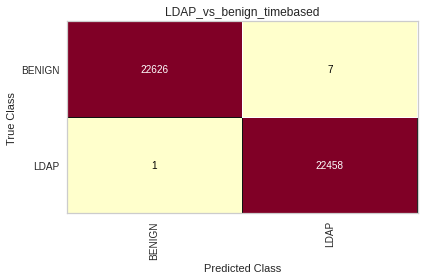

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


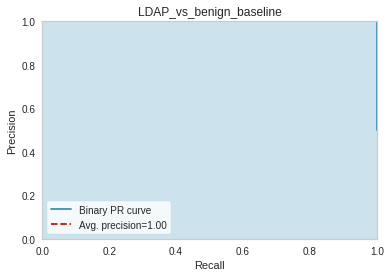

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


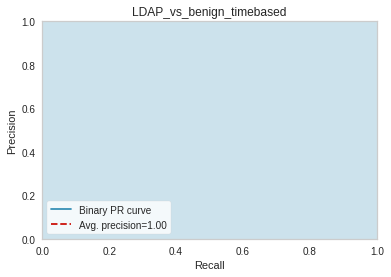

In [8]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [9]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/MSSQL_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/MSSQL_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/MSSQL_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/MSSQL_vs_benign.csv.pickle
Running experiment #3:	MSSQL
Baseline results
	Accuracy: 0.9999556462343653

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.9988689789763151

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


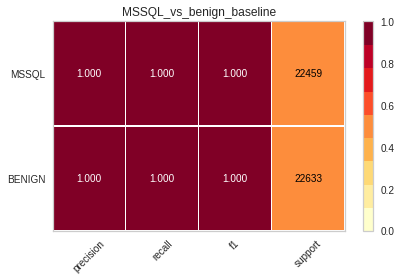

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


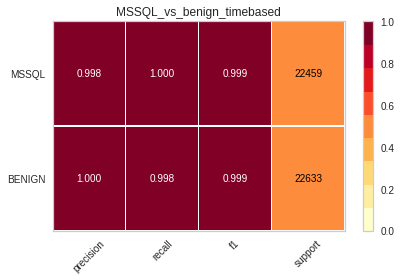

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


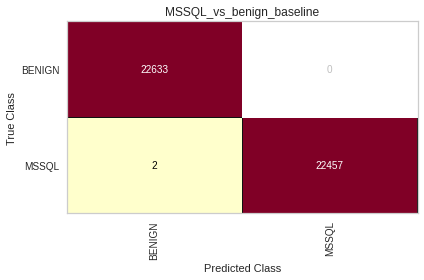

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


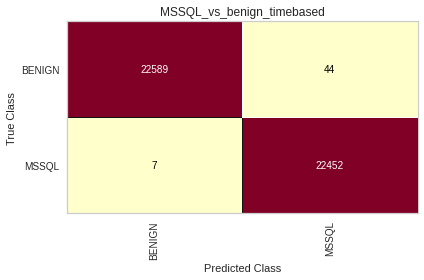

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


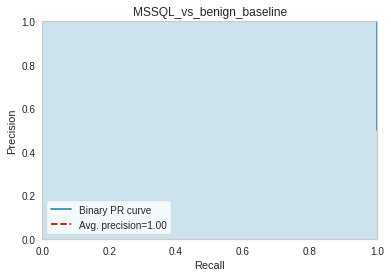

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


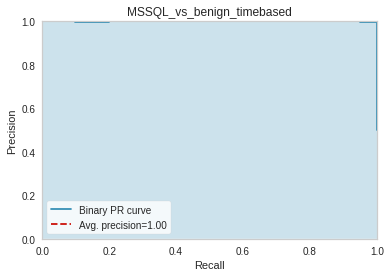

In [10]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [11]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/NetBIOS_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/NetBIOS_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/NetBIOS_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/NetBIOS_vs_benign.csv.pickle
Running experiment #4:	NetBIOS
Baseline results
	Accuracy: 0.9999112924687306

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.999112924687306

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00 

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


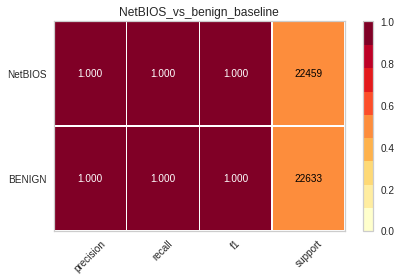

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


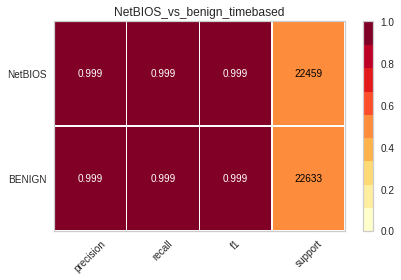

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


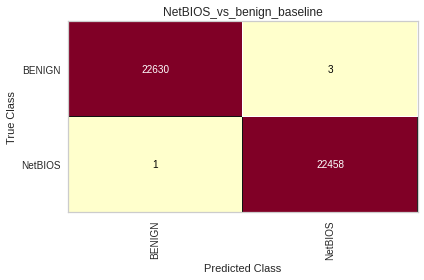

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


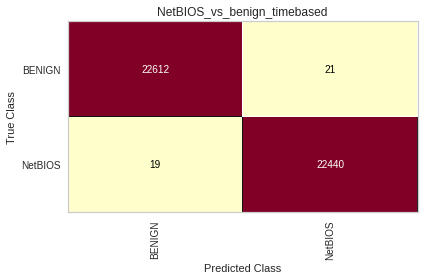

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


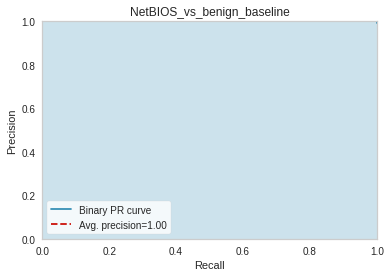

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


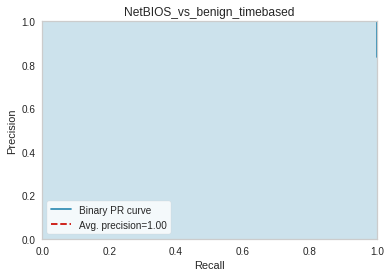

In [12]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [13]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/NTP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/NTP_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/NTP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/NTP_vs_benign.csv.pickle
Running experiment #5:	NTP
Baseline results
	Accuracy: 0.9995342854608357

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.9980040805464384

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


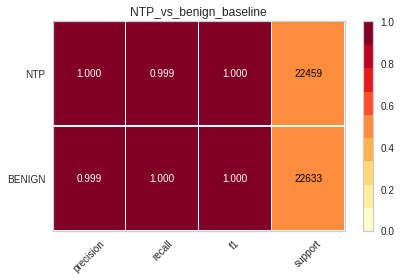

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


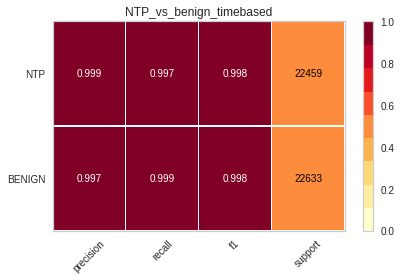

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


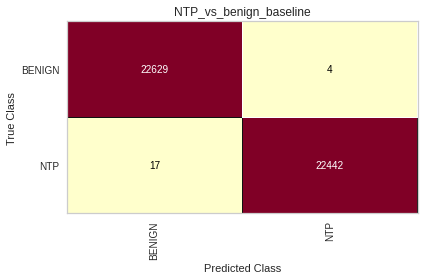

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


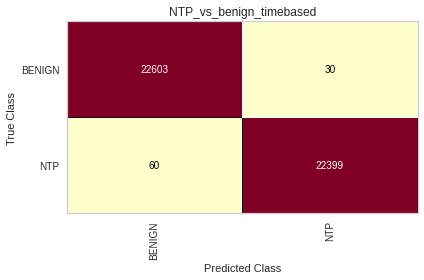

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


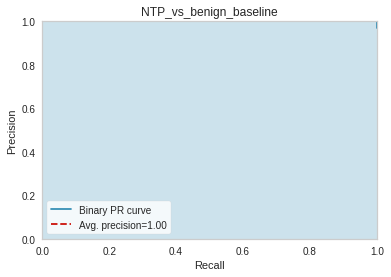

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


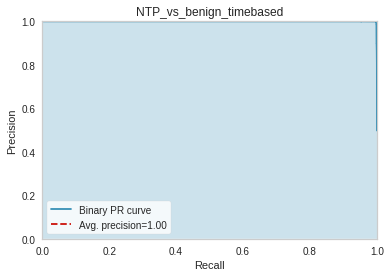

In [14]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [15]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/Portmap_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/Portmap_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/Portmap_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/Portmap_vs_benign.csv.pickle
Running experiment #6:	Portmap
Baseline results
	Accuracy: 0.9998891155859132

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.999179455335758

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00 

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


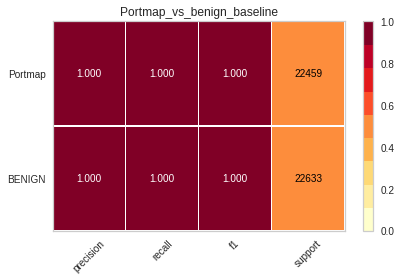

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


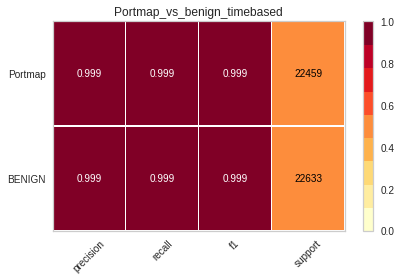

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


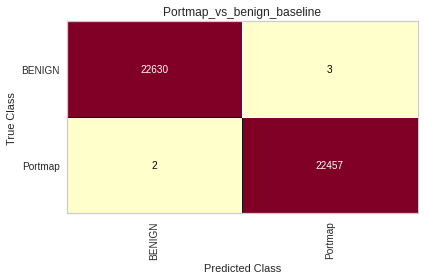

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


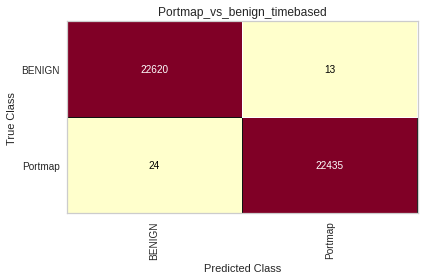

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


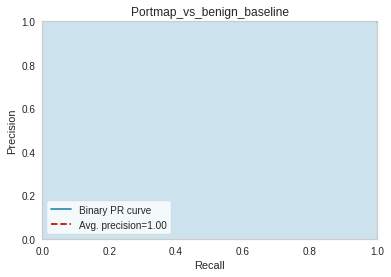

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


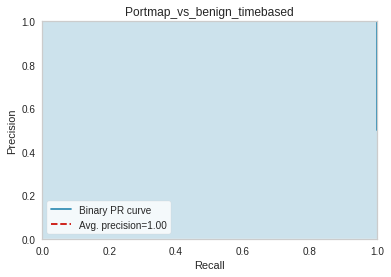

In [16]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [17]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/SNMP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/SNMP_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/SNMP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/SNMP_vs_benign.csv.pickle
Running experiment #7:	SNMP
Baseline results
	Accuracy: 0.9997782311718265

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.9993568703982968

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


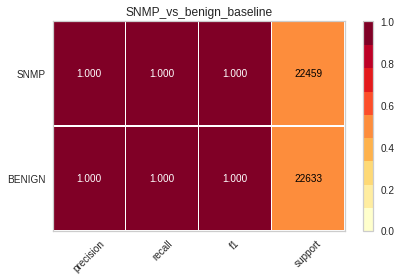

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


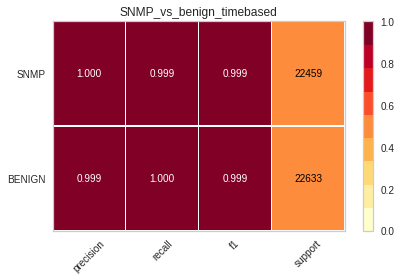

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


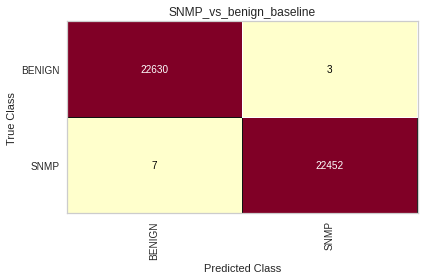

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


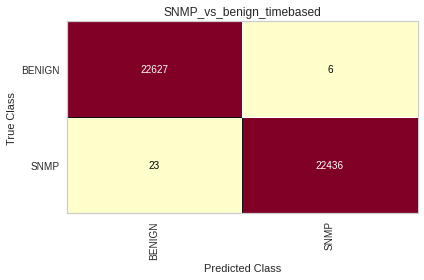

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


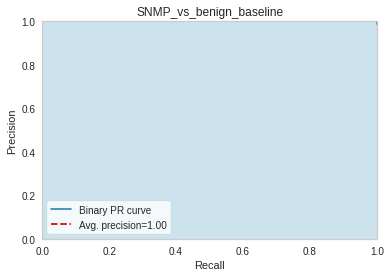

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


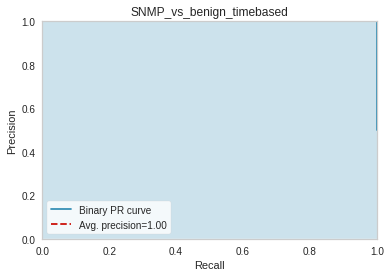

In [18]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [19]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/SSDP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/SSDP_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/SSDP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/SSDP_vs_benign.csv.pickle
Running experiment #8:	SSDP
Baseline results
	Accuracy: 0.9999556462343653

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.999179455335758

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     4

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


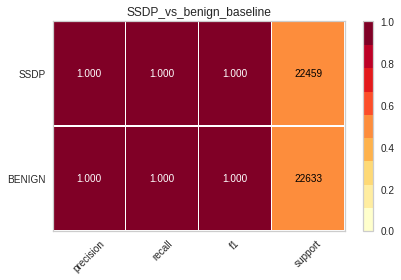

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


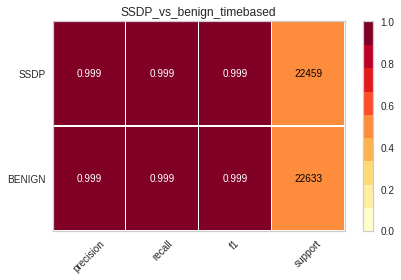

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


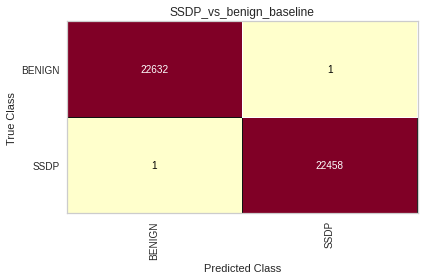

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


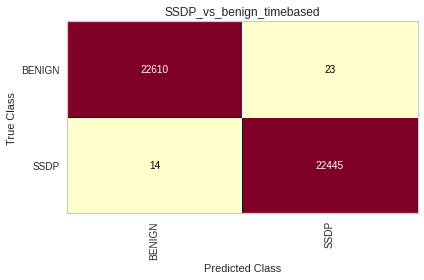

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


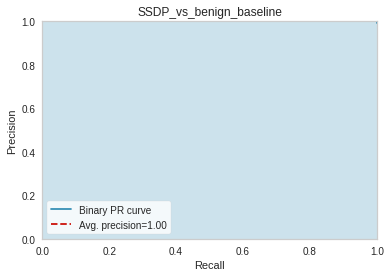

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


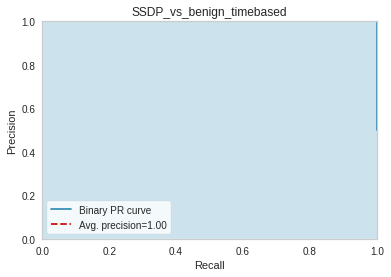

In [20]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [21]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/Syn_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/Syn_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/Syn_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/Syn_vs_benign.csv.pickle
Running experiment #9:	Syn
Baseline results
	Accuracy: 0.9998891155859132

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.9757384901978178

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     22633
           1       0.96      0.99      0.98     22459

    accuracy                           0.98     45092
   macro avg       0.98      0.98      0.98     45092

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


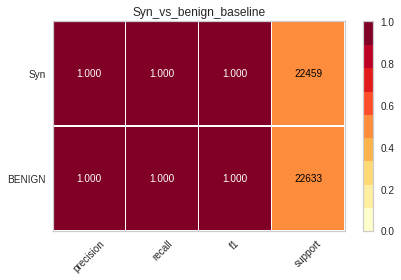

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


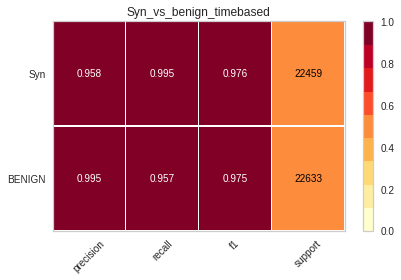

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


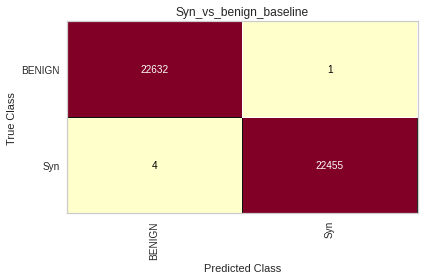

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


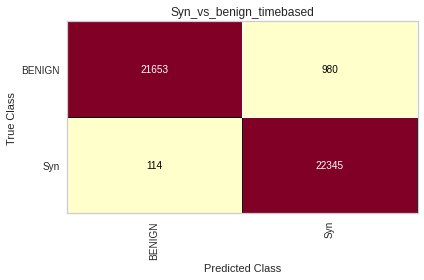

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


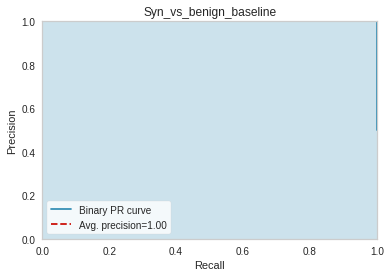

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


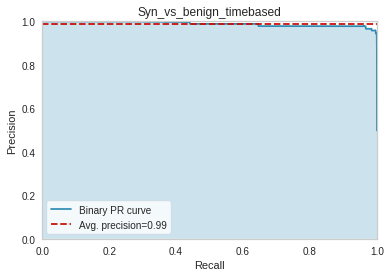

In [22]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [23]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/TFTP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/TFTP_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/TFTP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/TFTP_vs_benign.csv.pickle
Running experiment #10:	TFTP
Baseline results
	Accuracy: 0.9998004080546439

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.9969395901712055

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     22633
           1       1.00      0.99      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00    

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


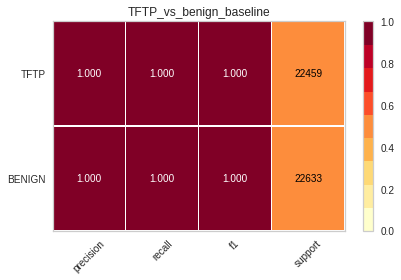

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


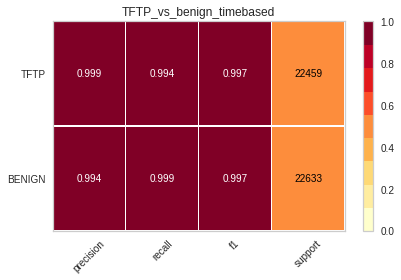

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


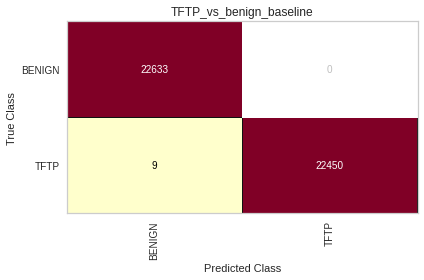

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


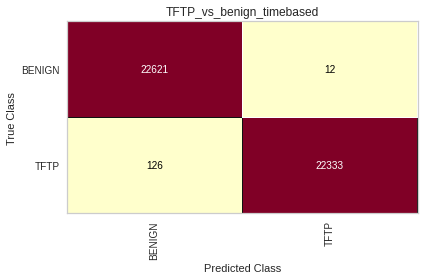

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


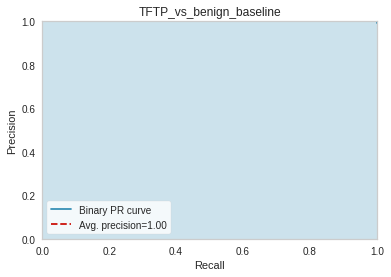

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


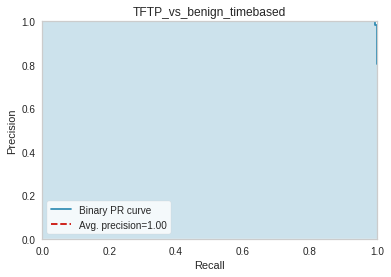

In [24]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [25]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/UDP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/UDP_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/UDP_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/UDP_vs_benign.csv.pickle
Running experiment #11:	UDP
Baseline results
	Accuracy: 0.9998891155859132

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.9993790472811142

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     4509

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


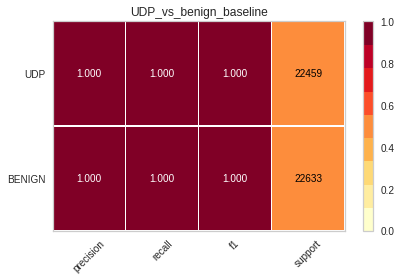

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


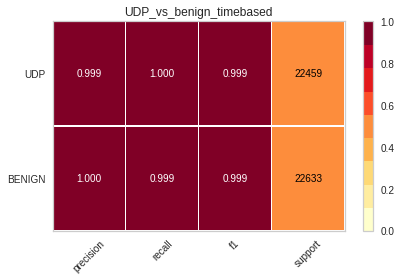

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


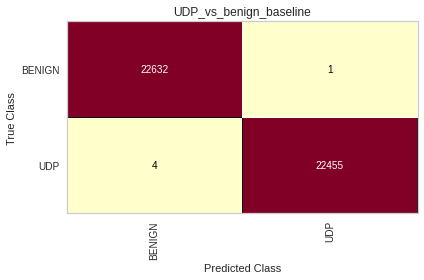

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


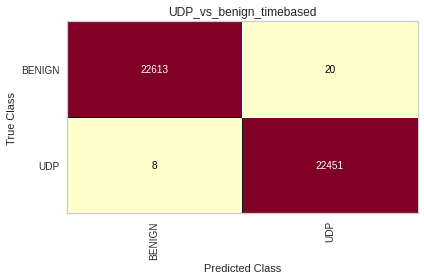

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


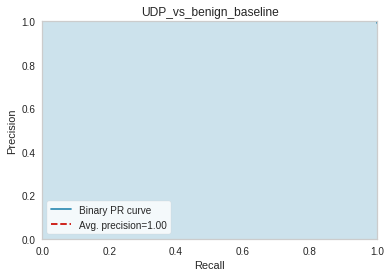

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


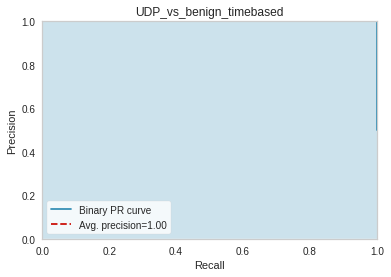

In [26]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

In [27]:
results = next(experiment)

Loading Dataset: ../../data/prepared/baseline/UDPLag_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/baseline/UDPLag_vs_benign.csv.pickle
Loading Dataset: ../../data/prepared/timebased/UDPLag_vs_benign.csv
	To Dataset Cache: ../../data/cache/ed/timebased/UDPLag_vs_benign.csv.pickle
Running experiment #12:	UDPLag
Baseline results
	Accuracy: 0.9998891155859132

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092


Time-based results
	Accuracy: 0.9853189035749135

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22633
           1       0.98      1.00      0.99     22459

    accuracy                           0.99     45092
   macro avg       0.99      0.99    

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


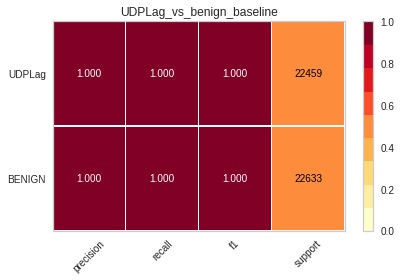

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


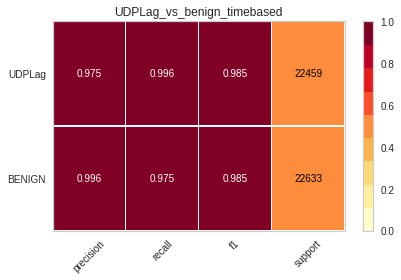

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


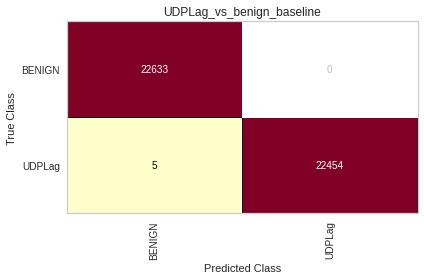

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


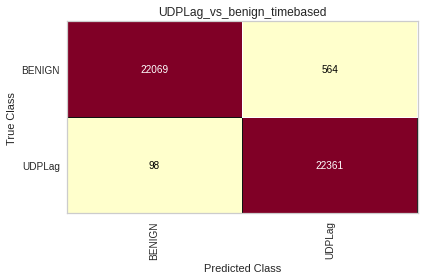

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


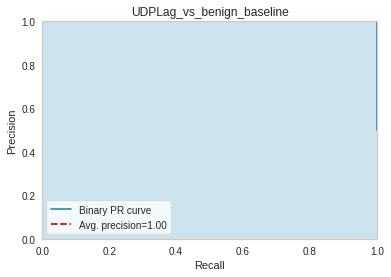

/home/drake/miniconda3/envs/ml/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


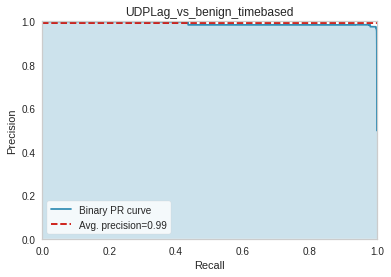

In [28]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])